# Example showcasing IO tasks

Notebook showing a workflow examples for downloading and saving EO imaging data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
from aenum import MultiValueEnum
from matplotlib.colors import ListedColormap, BoundaryNorm

from sentinelhub import BBox, CRS, DataCollection, MimeType, SentinelHubRequest, SHConfig

from eolearn.core import SaveTask, LoadTask, FeatureType, LinearWorkflow
from eolearn.io import SentinelHubInputTask, SentinelHubDemTask, SentinelHubEvalscriptTask, get_available_timestamps


## Prerequisites

### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://www.sentinel-hub.com/trial). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

### Credentials

Please follow the instructions at [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) to configure your `sentinelhub` installation. For Processing API request you need to obtain and set your `oauth` client id and secret. 

<div class="alert alert-info">

**Note:**
    
Instead of providing credentials here we could also configure them beforehand according to [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html).
</div>

In [2]:
# In case you put the credentials into the configuration file you can leave this unchanged

CLIENT_ID = ''
CLIENT_SECRET = ''

In [3]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '' or config.instance_id == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

## Request different types of layers and data collections to an eopatch

In this workflow example, the input task requests S2 L1C bands at 20m resolution, and other eotasks add `NDVI` features, digital elevation model `DEM`, S2 L2A bands.

### General parameters

In [4]:
# region of interest
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)

# time interval of downloaded data
time_interval = ('2018-04-01', '2018-05-01')

# maximal cloud coverage (based on Sentinel-2 provided tile metadata)
maxcc = .8

# resolution of the request (in metres)
resolution = 20

# time difference parameter (minimum allowed time difference; if two observations are closer than this, they will be mosaicked into one observation)
time_difference = datetime.timedelta(hours=2)

### Tasks

#### Task for Sentinel-2 L1C data

The `input_task` will download all 13 Sentinel-2 bands, together with `dataMask`. For all possible bands that can be downloaded from Sentinel-2 data, please see Sentinel Hub [documentation](https://docs.sentinel-hub.com/api/latest/#/data/Sentinel-2-L1C?id=available-bands-and-data).

In [5]:
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'],
    bands_feature=(FeatureType.DATA, 'L1C_data'),
    additional_data=[(FeatureType.MASK, 'dataMask')],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

#### Task for retrieving NDVI index

<div class="alert alert-info">

**Disclaimer:**
    
As we already have bands B04 and B08 from the previous task, we could calculate NDVI (or any other index) locally. This task serves as an example how one can use Sentinel Hub service to run the calculation.
</div>

In [6]:
indices_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: ["B03","B04","B08","dataMask"],
            output:[{
                id: "indices",
                bands: 2,
                sampleType: SampleType.FLOAT32
            }]
        }
    }

    function evaluatePixel(sample) {
        let ndvi = index(sample.B08, sample.B04);
        let ndwi = index(sample.B03, sample.B08);
        return {
           indices: [ndvi, ndwi]
        };
    }
"""

<div class="alert alert-info">

**Note:**
    
Requesting float32 data (`SampleType.FLOAT32`) from SH service consumes twice the amount of processing units compared to requesting digital numbers. Please see [processing unit](https://docs.sentinel-hub.com/api/latest/\#/API/processing_unit) documentation for details.
</div>

In [7]:
# this will add two indices: ndvi and ndwi
add_indices = SentinelHubEvalscriptTask(
    features=[(FeatureType.DATA, 'indices')],
    evalscript=indices_evalscript,
    data_collection=DataCollection.SENTINEL2_L1C,
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

#### Task for Digital Elevation Model Data

In [8]:
add_dem = SentinelHubDemTask(
    data_collection=DataCollection.DEM_COPERNICUS_30, 
    resolution=resolution, 
    config=config
)

#### Task for Sentinel-2 L2A and SCL data

With `SentinelHubInputTask` it is possible to request both L2A and SCL data in one go, optimised for smallest processing unit costs.

In [9]:
add_l2a_and_scl = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],
    bands_feature=(FeatureType.DATA, 'L2A_data'),
    additional_data=[(FeatureType.MASK, 'SCL')],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

#### Task for saving the eopatch

In [10]:
save = SaveTask('io_example', overwrite_permission=2, compress_level=1)

### Run workflow

In [11]:
workflow = LinearWorkflow(input_task, add_indices, add_l2a_and_scl, add_dem, save)

result = workflow.execute({
    input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
    save: {'eopatch_folder': 'eopatch'}
})

Check contents of eopatch

In [12]:
eopatch = result.eopatch()
eopatch

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(8, 297, 497, 13), dtype=float32)
    L2A_data: numpy.ndarray(shape=(8, 297, 497, 12), dtype=float32)
    indices: numpy.ndarray(shape=(8, 297, 497, 2), dtype=float32)
  }
  mask: {
    SCL: numpy.ndarray(shape=(8, 297, 497, 1), dtype=uint8)
    dataMask: numpy.ndarray(shape=(8, 297, 497, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    dem: numpy.ndarray(shape=(297, 497, 1), dtype=uint16)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    size_x: 497
    size_y: 297
    time_difference: datetime.timedelta(seconds=1)
    time_interval: None
  }
  bbox: BBox(((5.6, 52.63), (5.75, 52.68)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2018, 4, 3, 10, 41, 5, tzinfo=tzutc()), ...], length=8
)

### Plot results

#### Sentinel-2 L1C RGB bands

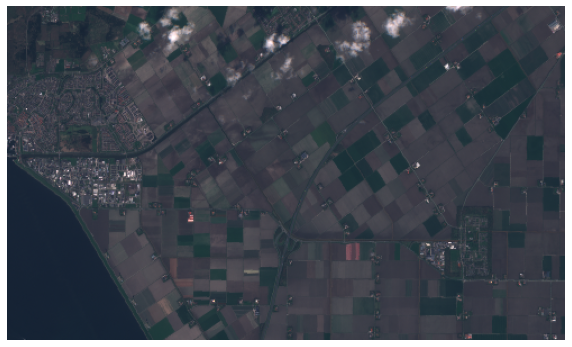

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(eopatch.data['L1C_data'][3][..., [3,2,1]] * 2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);

#### NDVI data

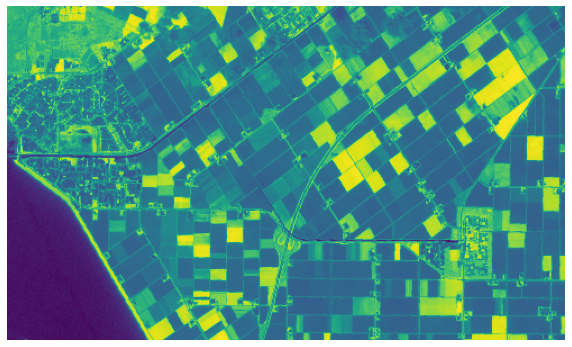

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['indices'][3][...,0].squeeze());
plt.axis(False);

#### NDWI data

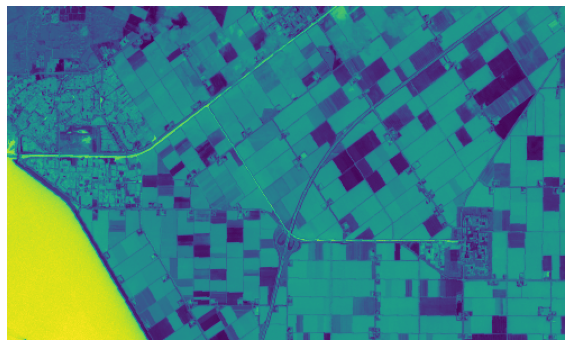

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['indices'][3][...,1].squeeze());
plt.axis(False);

#### Sentinel-2 L2A RGB bands

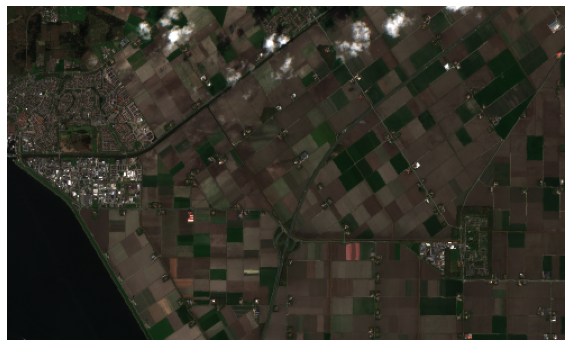

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(eopatch.data['L2A_data'][3][...,[3,2,1]] * 2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);

#### Sentinel-2 Scene Classification Layer (from Sen2cor)

In [17]:
class SCL(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA = 'no data', 0, '#000000'
    SATURATED_DEFECTIVE = 'saturated / defective', 1, '#ff0004'
    DARK_AREA_PIXELS = 'dark area pixels', 2, '#868686'
    CLOUD_SHADOWS = 'cloud shadows', 3, '#774c0b'
    VEGETATION = 'vegetation', 4, '#10d32d'
    BARE_SOILS = 'bare soils', 5, '#ffff53'
    WATER = 'water', 6, '#0000ff'
    CLOUDS_LOW_PROBA = 'clouds low proba.', 7, '#818181'
    CLOUDS_MEDIUM_PROBA = 'clouds medium proba.', 8, '#c0c0c0'
    CLOUDS_HIGH_PROBA = 'clouds high proba.', 9, '#f2f2f2'
    CIRRUS = 'cirrus', 10, '#bbc5ec'
    SNOW_ICE = 'snow / ice', 11, '#53fffa'

    @property
    def rgb(self):
        return [c/255. for c in self.rgb_int]

    @property
    def rgb_int(self):
        hex_val = self.values[2][1:]
        return [int(hex_val[i: i + 2], 16) for i in (0, 2, 4)]

scl_bounds = [-0.5 + i for i in range(len(SCL)+1)]
scl_cmap = ListedColormap([x.rgb for x in SCL], name="scl_cmap")
scl_norm = BoundaryNorm(scl_bounds, scl_cmap.N)

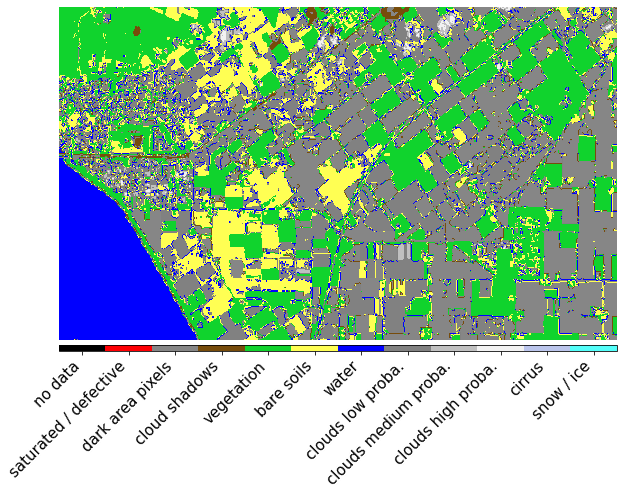

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
im = plt.imshow(eopatch.mask['SCL'][3].squeeze(), cmap=scl_cmap, norm=scl_norm);
plt.axis(False)

cb = fig.colorbar(im, orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.values[1] for entry in SCL])
cb.ax.set_xticklabels([entry.values[0] for entry in SCL], rotation=45, fontsize=15, ha='right');

#### Mapzen Digital Elevation Model

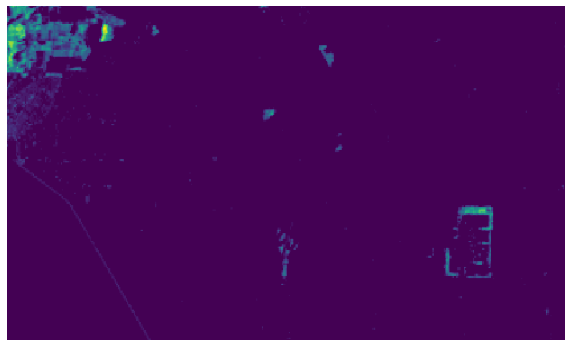

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(eopatch.data_timeless['dem'].squeeze());
plt.axis(False);

## Load in saved eopatch

In [20]:
load = LoadTask('io_example')

In [21]:
new_eopatch = load.execute(eopatch_folder='eopatch')